# Explore data for traits and Sentinel-2 bands

This notebook explores the trait data for all traits, using summary statistics and plots. It also explores the distributions of the predictor variables.

## Imports and constants

In [1]:
from pathlib import Path
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

from src.data_utils import get_outlier_iqr

In [2]:
VARS = [
    'N.Percent',
    'P.Percent',
    'K.Percent',
    'Ca.Percent',
    'Mg.Percent',
    'C.Percent',
    'Amax',
    'Asat',
    'Area.cm2',
    'Dry.mass.g',
    'Fresh.mass.g',
    'Thickness.mm',
    'SLA.g.m2'
]
CENTRAL_WAVELENTGHS = {
    'B2_real': 490,
    'B3_real': 560,
    'B4_real': 665,
    'B5_real': 705,
    'B6_real': 740,
    'B7_real': 783,
    'B8_real': 842,
    'B11_real': 1610,
    'B12_real': 2190
}

### List variables

In [66]:
# All commented variables don't seem to be included in the paper.
# ** indicates same value for all pixels in a plot.
bands = [
    'B2_real', # Blue band, 490 nm
    'B3_real', # Green band, 560 nm
    'B4_real', # Red band, 665 nm
    'B5_real', # Red edge band, 705 nm
    'B6_real', # Red edge band, 740 nm
    'B7_real', # Red edge band, 783 nm
    'B8_real', # NIR band, 842 nm
    'B11_real', # SWIR band, 1610 nm
    'B12_real' # SWIR band, 2190 nm
    # 'B8a_real' # NIR band, 865 nm
]
spectral_indices = [
    # 'BNDVI',
    # 'BNDVI_Corr',
    # 'BNDVI_Entropy',
    # 'EVI2', # 2.5 × (NIR - Red) / (NIR + 2.4 × Red + 1)
    # 'EVI2_Corr',
    # 'EVI2_Entropy',
    'MCARI',
    'MCARI_Corr',
    'MCARI_Entropy',
    'MSAVI2', # (2 × NIR + 1 - √((2 × NIR + 1)² - 8 × (NIR - Red))) / 2
    'MSAVI2_Corr',
    'MSAVI2_Entropy',
    'NDRE', #  (NIR - RedEdge)/(NIR + RedEdge)
    'NDRE_Corr',
    'NDRE_Entropy',
    # 'TCARI',
    # 'TCARI_Corr',
    # 'TCARI_Entropy'
]
climate_vars = [
    'CWD', # Climate Water Deficit
    # 'PRE',
    'SoilMoist', # Soil Moisture
    'SRAD', # Solar irradiance
    'Tmax', # Mean annual maximum temperature
    # 'vpd'
]
soil_vars = [
    'Slope', # Terrain slope
    # 'sand', # Sand content
    'sand_perc_plot', # Sand content percentage
    # 'ph', # Soil pH
    'ph_h20_plot', # Soil pH in water 
    # 'clay', # Clay content **
    'clay_perc_plot', # Clay content percentage **
    # 'cec', # Cation exchange capacity **
    'CEC_mmol_kg_plot', # Cation exchange capacity **
]

cols = [*bands, *spectral_indices, *climate_vars, *soil_vars]

## Load trait data from master table

In [67]:
dpath = Path('/Users/campbelli/Documents/mini-project/data')
df = pd.read_csv(dpath / 'Master_Table_Modelling_LOWCORRELATIONS_wB8A.csv')

/var/folders/g5/h0yjdszs0pz_qr3k5z8bjjq80000gp/T/ipykernel_2953/2405339980.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dpath / 'Master_Table_Modelling_LOWCORRELATIONS_wB8A.csv')


Select only the pixels with 70% of the basal area covered and only community-weighted means.

In [68]:
cwms = df[(df['PercentCovered'] == '70') & (df['Type'] == 'CWMean')]
cwms.loc[:, 'TraitValue'] = pd.to_numeric(cwms['TraitValue'], errors='raise')

In [69]:
var_cwm = cwms[cwms['variable'] == VARS[0]]

## Inspect Trait Data

Not all plots have data for all the traits. Find the number of plots with comprehensive trait data.

In [7]:
# Find the plots with data for all variables
intersection_plot_ids = set(cwms['New_Plot'])
for variable in cwms['variable'].unique():
    intersection_plot_ids &= set(cwms[cwms['variable'] == variable]['New_Plot'])

print(f'Number of plots with full trait data: {len(list(intersection_plot_ids))}')

Number of plots with full trait data: 932


### Inspect trait distributions by location

In [25]:
def plot_trait_distribution_by_location(df, variable):
    _, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x='Location', y='TraitValue', data=df[df['variable'] == variable], ax=ax)
    ax.set_title(f'{variable} Trait Data Distribution by Location')
    ax.set_xlabel('Location')
    ax.set_ylabel('Trait Value')
    plt.xticks(rotation=45)
    plt.tight_layout()

    return ax

In [ ]:
# Plot trait data distributions by location on the same plot
for variable in cwms.variable.unique():
    fig_path = Path('/Users/campbelli/Documents/geofm-plant-traits/figures/traits')
    ax = plot_trait_distribution_by_location(cwms, variable)
    plt.savefig(fig_path / f'{variable}_trait_distribution_by_location.png', dpi=300)
    plt.show()

In [62]:
# Use 2-D t-SNE plots to visualize the trait data with soil and climate vars.
def plot_2D_tsne(df, variable):

    cols = [*climate_vars, *soil_vars]
    df = df[df['variable'] == variable]

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(df[cols])

    # Create a DataFrame with the t-SNE results
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['Location'] = df['Location'].values

    # Plot the t-SNE results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Location', data=tsne_df)
    plt.title(f't-SNE Plot of {variable} with climate and soil variables')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Location')
    plt.tight_layout()
    return plt.gca()

# Use 3-D t-SNE plots to visualize the trait data
def plot_3D_tsne(df, variable):
    # Select the relevant columns for t-SNE
    data = df[df['variable'] == variable][cols]
    data = data.dropna()

    # Perform t-SNE
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(data)

    # Create a DataFrame with the t-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=['t-SNE1', 't-SNE2', 't-SNE3'])
    tsne_df['Location'] = df[df['variable'] == variable]['Location'].values

    # Plot the t-SNE results
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], tsne_df['t-SNE3'], 
                         c=tsne_df['Location'].astype('category').cat.codes, 
                         cmap='viridis')
    ax.set_xlabel('t-SNE1')
    ax.set_ylabel('t-SNE2')
    ax.set_zlabel('t-SNE3')
    plt.title(f't-SNE Plot for {variable}')
    plt.colorbar(scatter, label='Location')

    return ax

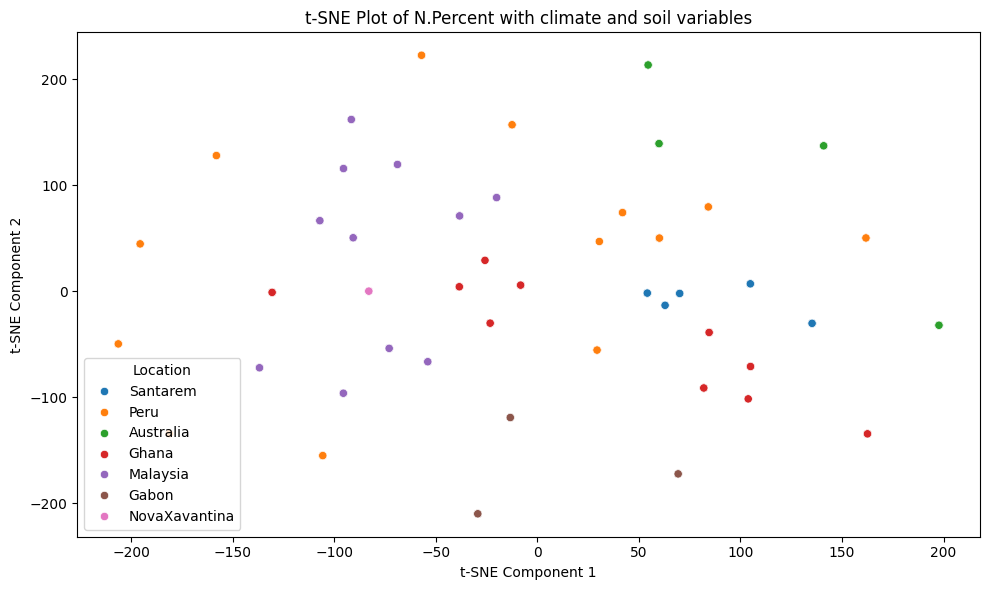

In [56]:
variable = 'N.Percent'
fig_path = Path('/Users/campbelli/Documents/geofm-plant-traits/figures/traits')
ax = plot_2D_tsne(cwms, variable)
plt.savefig(fig_path / f'{variable}_2d_tsne_plot.png', dpi=300)
plt.show()

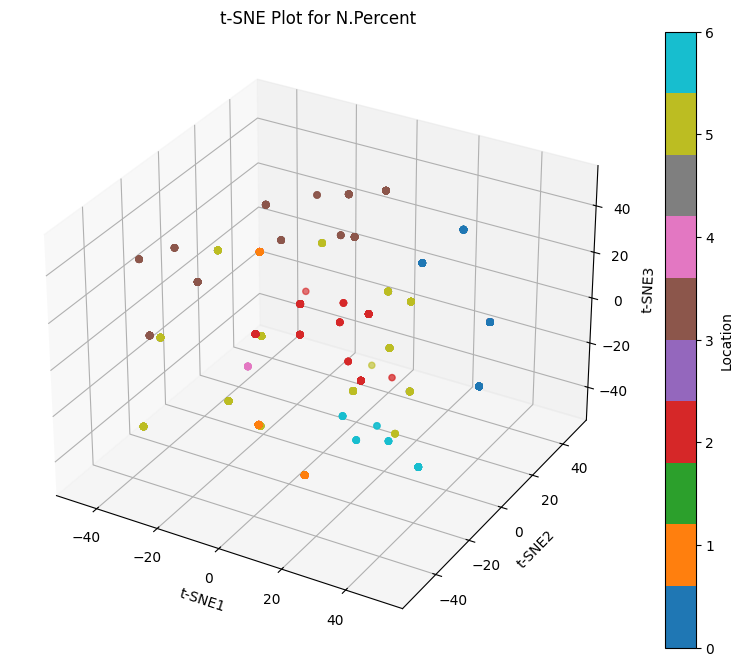

In [61]:
ax = plot_3D_tsne(cwms, variable)
# plt.savefig(fig_path / f'{variable}_3d_tsne_plot.png', dpi=300)
plt.show()

## Inspect predictor variables data

### Look at what parts of the spectrum are sampled by the Sentinel-2 bands

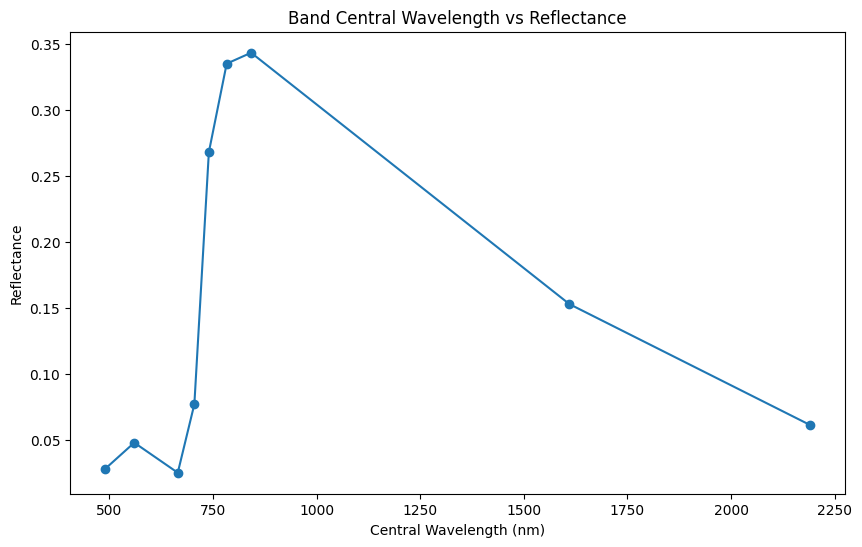

In [ ]:
# Plot band central wavelength versus spectral response
plt.figure(figsize=(10, 6))
reflectances = {band: var_cwm[band].iloc[0] for band in CENTRAL_WAVELENTGHS.keys()}
plt.plot(CENTRAL_WAVELENTGHS.values(), reflectances.values(), marker='o')
plt.title("Band Central Wavelength vs Reflectance")
plt.xlabel("Central Wavelength (nm)")
plt.ylabel("Reflectance")
plt.show()

### Test multi-collinearity of predictors

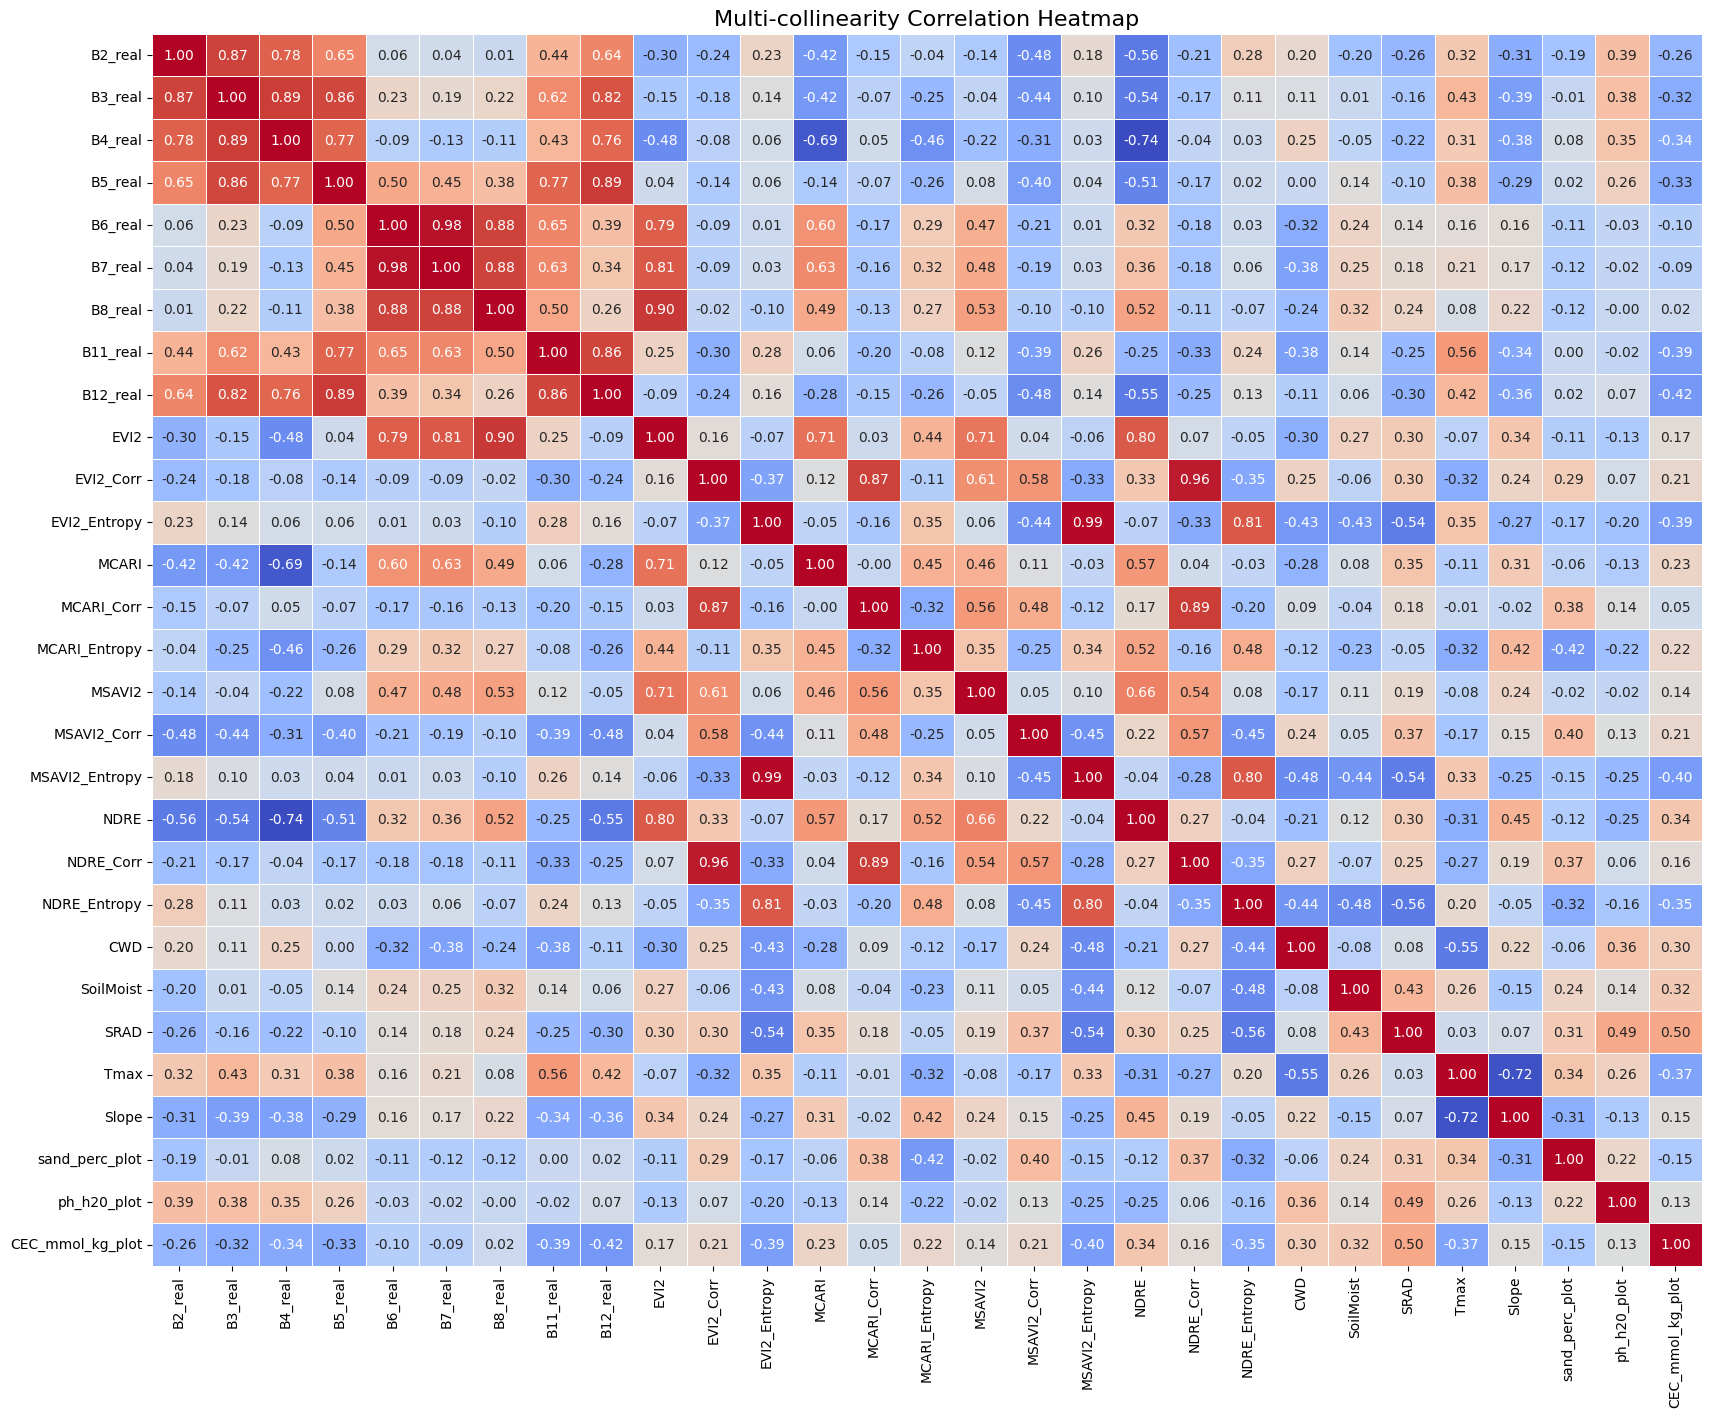

In [ ]:
# Correlation matrix
X = var_cwm[cols].dropna(axis=0, how='any')
correlation_matrix = X.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=False)

# Title for the heatmap
plt.title("Multi-collinearity Correlation Heatmap", fontsize=16)

# Show the heatmap
plt.show()

### Calculate variance inflation factor between predictor variables

In [ ]:
def calc_vif(X: pd.DataFrame):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [ ]:
X = var_cwm[bands].dropna(axis=0)
calc_vif(X)

,Feature,VIF
0,B2_real,22.209338
1,B3_real,263.565888
2,B4_real,84.222294
3,B5_real,383.653091
4,B6_real,962.211174
5,B7_real,844.186600
6,B8_real,183.137850
7,B11_real,344.113405
8,B12_real,353.516364


In [ ]:
X = var_cwm[spectral_indices].dropna(axis=0)
calc_vif(X)

,Feature,VIF
0,MCARI,10.082907
1,MCARI_Corr,2246.069650
2,MCARI_Entropy,81.578511
3,MSAVI2,4.801290
4,MSAVI2_Corr,255.527648
5,MSAVI2_Entropy,65.093804
6,NDRE,157.380338
7,NDRE_Corr,2187.059740
8,NDRE_Entropy,90.448470


In [ ]:
X = var_cwm[climate_vars].dropna(axis=0)
calc_vif(X)

,Feature,VIF
0,CWD,4.871014
1,SoilMoist,3.450494
2,SRAD,46.591237
3,Tmax,32.748356


In [ ]:
X = var_cwm[soil_vars].dropna(axis=0)
calc_vif(X)

,Feature,VIF
0,Slope,2.748633
1,sand_perc_plot,5.314712
2,ph_h20_plot,9.570760
3,CEC_mmol_kg_plot,2.337204


In [ ]:
X = var_cwm[cols].dropna(axis=0)
calc_vif(X)

,Feature,VIF
0,B2_real,48.194835
1,B3_real,358.006000
2,B4_real,795.889996
3,B5_real,1867.203444
4,B6_real,1201.701296
5,B7_real,1210.375527
6,B8_real,11149.588087
7,B11_real,1194.438499
8,B12_real,855.557463
9,EVI2,23841.631689


## Reconstruct auxiliary variables from Sentinel-2 bands

This is a test to see whether the information in the auxiliary variables important for making good predictions, as demonstrated by the high feature importances, is contained within the spectral bands. 

We use the same random forest regressor to predict each auxiliary variable.

In [ ]:
def fit_predict_rf(X, y):
    # Split the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the RandomForestRegressor model.
    estimator = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit the model to the training data
    estimator.fit(X_train, y_train)

    # Predict the trait values
    predictions = estimator.predict(X_test)

    # Calculate metrics.
    r_squared = estimator.score(X_test, y_test)
    rmse = root_mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100

    return estimator, [r_squared, rmse, mae, mape]

In [ ]:
var_cwm = cwms[cwms['variable'] == 'N.Percent']
rebuild_vars = [*climate_vars, *soil_vars, *spectral_indices]
var_reconstructions = pd.DataFrame(index=rebuild_vars, columns=['R-squared', 'VIF', 'RMSE', 'MAE', 'MAPE'])

for rebuild_var in rebuild_vars:
    # Remove outliers from the dataset.
    outlier_indices = var_cwm.groupby('Location')[rebuild_var].apply(get_outlier_iqr, zlim=4).reset_index()['level_1']
    X = var_cwm.drop(outlier_indices)[[*bands, rebuild_var]].dropna(axis=0)
    var_reconstructions.loc[rebuild_var, 'VIF'] = variance_inflation_factor(X.values, 9)

    X = X.drop(columns=rebuild_var)
    y = var_cwm.loc[X.index.values, rebuild_var]

    _, metrics = fit_predict_rf(X, y, verbose=False)
    var_reconstructions.loc[rebuild_var, 'R-squared'] = metrics[0]
    var_reconstructions.loc[rebuild_var, 'RMSE'] = metrics[1]
    var_reconstructions.loc[rebuild_var, 'MAE'] = metrics[2]
    var_reconstructions.loc[rebuild_var, 'MAPE'] = metrics[3]

    # Plot the pairplot for the current variable
    opath = f'figures/{rebuild_var}_pairplot.png'
    if not Path(opath).exists():
        print(f'Plotting {rebuild_var}')
        sns.pairplot(X, diag_kind='kde', kind='scatter').savefig(opath)
        plt.close()

var_reconstructions.sort_values(by='MAPE', ascending=True, inplace=True)
var_reconstructions

,R-squared,VIF,RMSE,MAE,MAPE
MSAVI2_Corr,0.907218,40.033832,0.013386,0.007035,0.752631
NDRE_Corr,0.592129,37.117769,0.040092,0.01091,1.51231
NDRE,0.879483,42.586371,0.026548,0.007909,1.70736
MCARI_Corr,0.34366,39.96136,0.048495,0.012896,1.850153
Tmax,0.918227,66.14493,1.038485,0.49999,2.0051
SRAD,0.793462,30.899641,10.764489,5.386079,2.958787
ph_h20_plot,0.895716,32.216654,0.25608,0.139471,3.031389
MSAVI2,0.39891,9.570937,0.152088,0.025508,4.257683
MCARI_Entropy,0.927447,22.456535,0.429347,0.285161,4.453689
MCARI,0.969285,47.506797,0.010202,0.005505,5.907841


Almost every variable can be predicted by the Sentinel-2 bands with less than 10% MAPE. This is strong evidence that the required information is present within the bands. 

Other potential factors that produce these results could be the low resolution of many variables resulting in few unique values, e.g., 
- CWD: 22 unique values
- SoilMoist: 22
- SRAD: 22
- Tmax: 22
- Slope: 28
- sand_perc_plot: 27
- ph_h20_plot: 27
- CEC_mmol_kg_plot: 27


In [4]:
from src.data_utils import LabelledTraitData

In [29]:
pred_df = pd.DataFrame()
trait_df = pd.DataFrame()

for var in VARS:
    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )
    traits = pd.concat([dataset.train_labels, dataset.test_labels, dataset.val_labels])
    traits.rename(columns={'TraitValue': var}, inplace=True)
    trait_df = trait_df.join(traits, how='outer')

    preds = pd.concat([dataset.train_data, dataset.test_data, dataset.val_data])
    pred_df = pred_df.combine_first(preds)

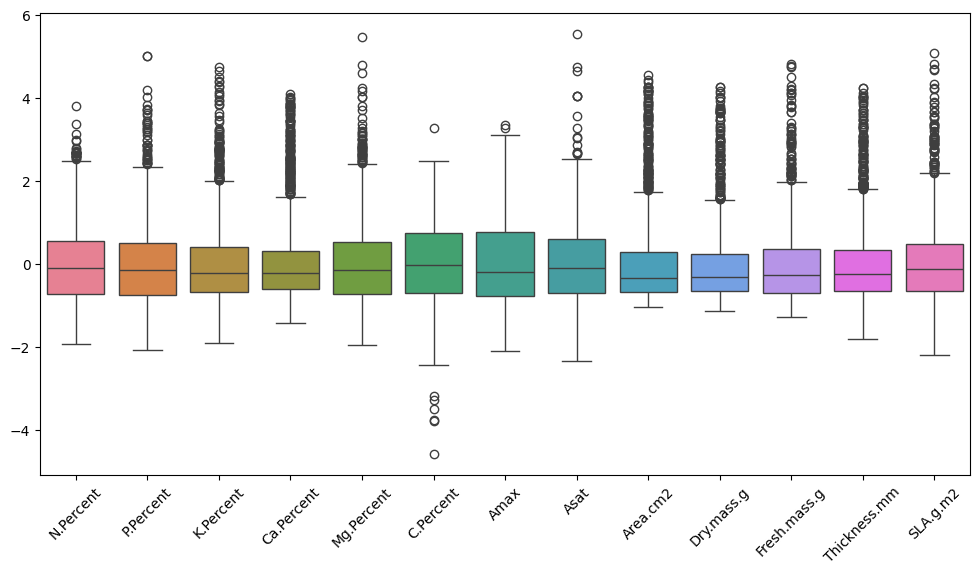

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(trait_df)
plt.gca().tick_params(axis='x', rotation=45)

<Axes: ylabel='Density'>

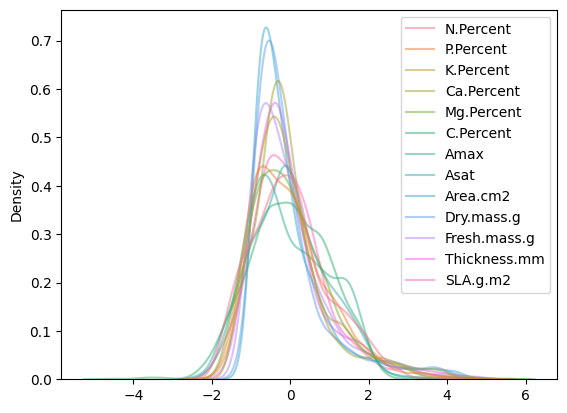

In [11]:
# Visualise whether there are clusters of values for each trait
sns.kdeplot(trait_df, fill=False, common_norm=False, alpha=0.5)

<Axes: >

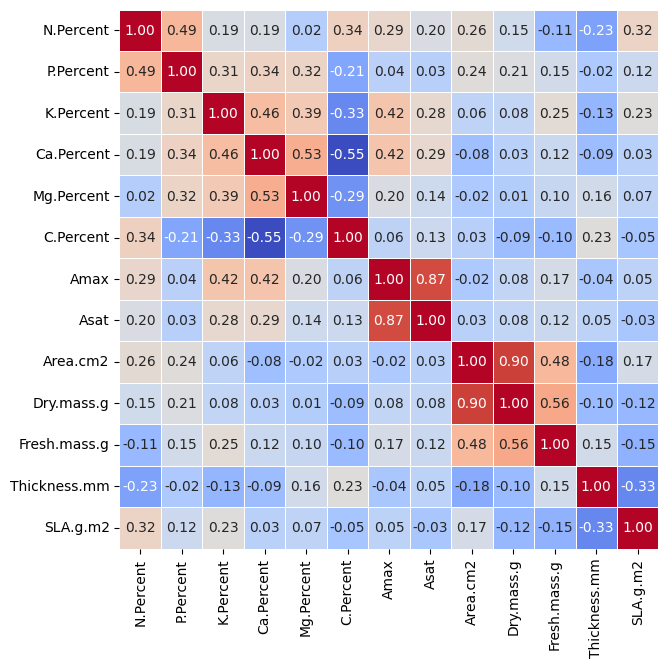

In [19]:
plt.figure(figsize=(7, 7))
corr_matrix = trait_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=False, square=True)

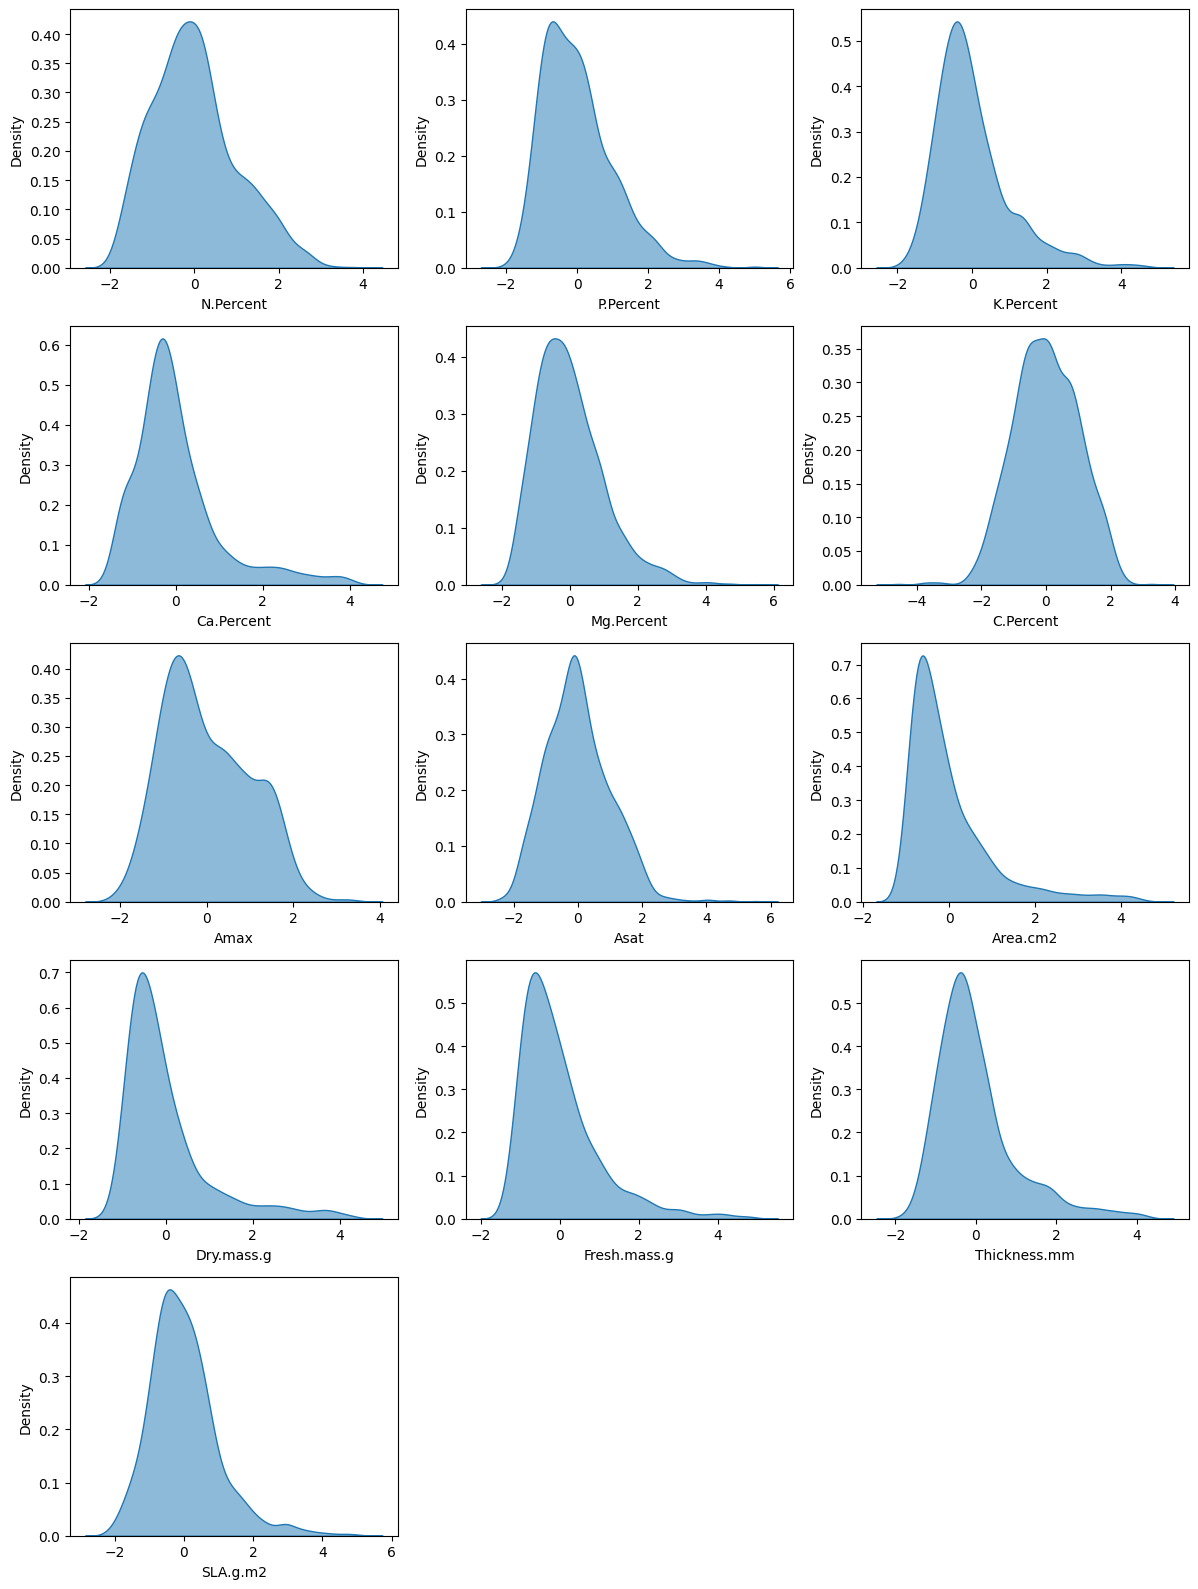

In [21]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 16))

# remove empty subplots
for j in range(len(VARS), len(axes.flat)):
    axes.flat[j].remove()

for var in VARS:
    sns.kdeplot(trait_df[var], ax=axes.flat[VARS.index(var)], fill=True, common_norm=False, alpha=0.5)

plt.tight_layout()

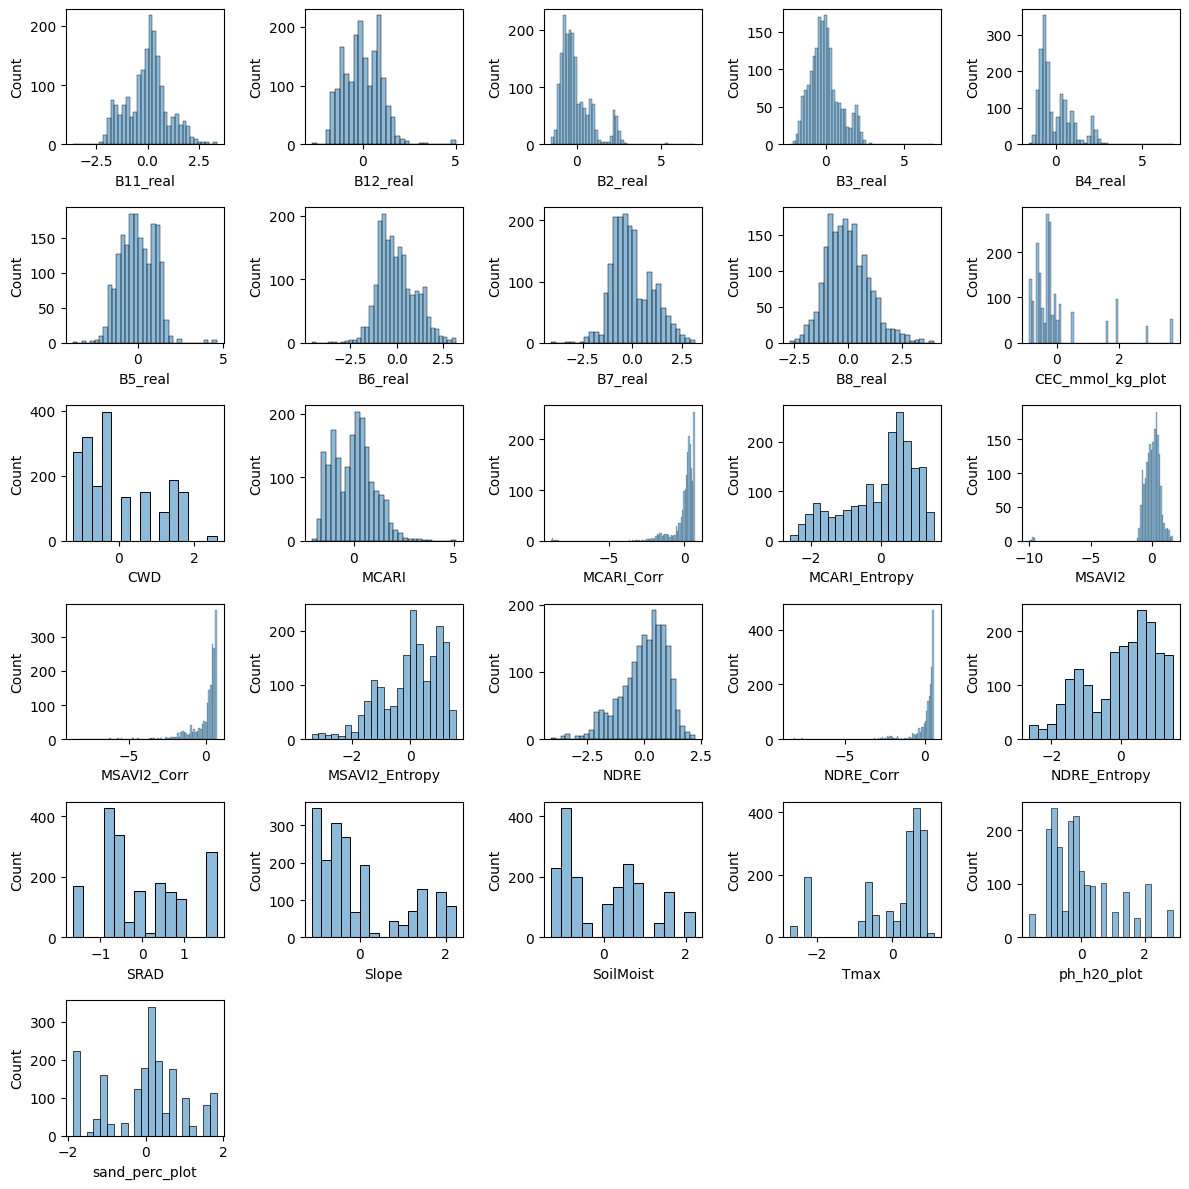

In [39]:
pred_vars = pred_df.columns
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(12, 12))

# remove empty subplots
for j in range(len(pred_vars), len(axes.flat)):
    axes.flat[j].remove()

for i, pred_var in enumerate(pred_vars):
    sns.histplot(pred_df[pred_var], ax=axes.flat[i], fill=True, common_norm=False, alpha=0.5)

plt.tight_layout()